In [ ]:
__author__ = "Phillip Lakaschus"
__email__ = "lakaschus@th.physik.uni-frankfurt.de"

TODO:
Compare with 

https://github.com/wme7/Aero-matlab/tree/master/cfdbook/chap10.8

How to express the Euler equations in an appropriate form: 

https://math.stackexchange.com/questions/1836866/computing-the-jacobian-of-the-euler-equations

https://math.stackexchange.com/questions/750832/the-matrix-a-in-the-system-of-euler-equations?rq=1

In [6]:
def spectral_radius(rho, m, e):
  """ spectral radius of matrix """
  #rho, m, e = u[:int(len(u)/3)], u[int(len(u)/3):int(len(u)*2/3)], u[int(2/3*len(u)):] 
  ev1 = m/rho
  ev2 = m/rho - np.sqrt((1 - gam)*gam*rho**4*(m**2 - 2*e*rho))/(np.sqrt(2)*rho**3)
  ev3 = m/rho + np.sqrt((1 - gam)*gam*rho**4*(m**2 - 2*e*rho))/(np.sqrt(2)*rho**3)
  res = np.maximum(np.maximum(ev1, ev2), ev3)
  return (res > np.zeros(res.shape)).astype(int)*res

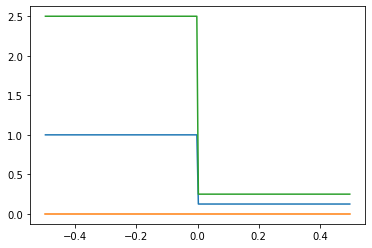

38.675100803375244


<Figure size 480x600 with 0 Axes>

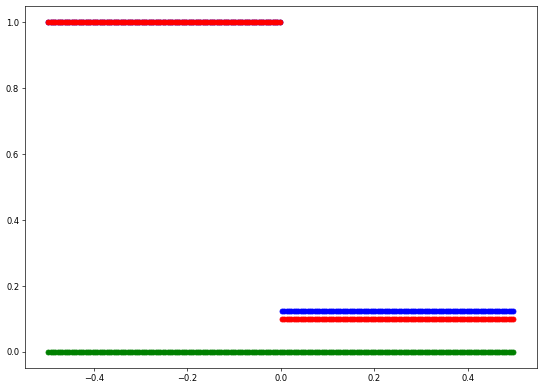

0.0


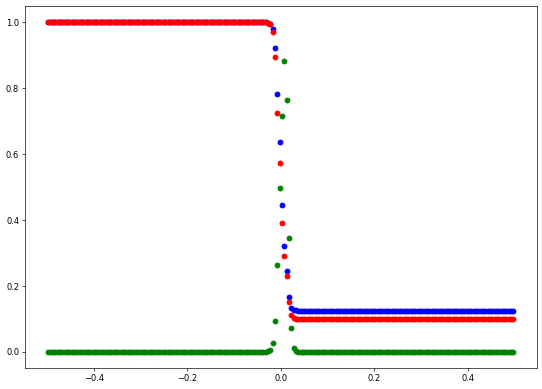

0.008303030303030303


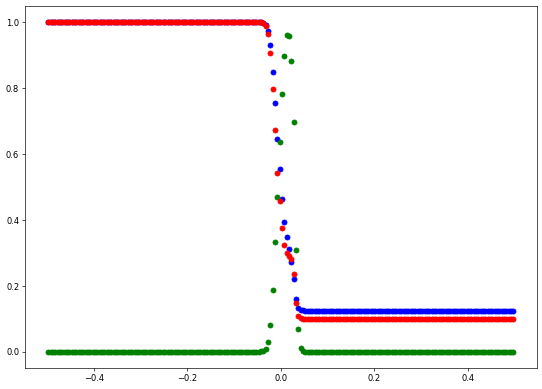

0.016606060606060607


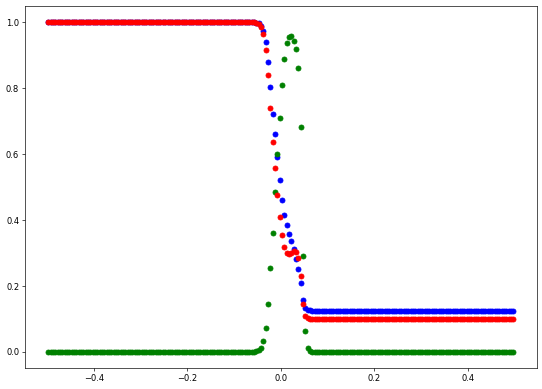

0.02490909090909091


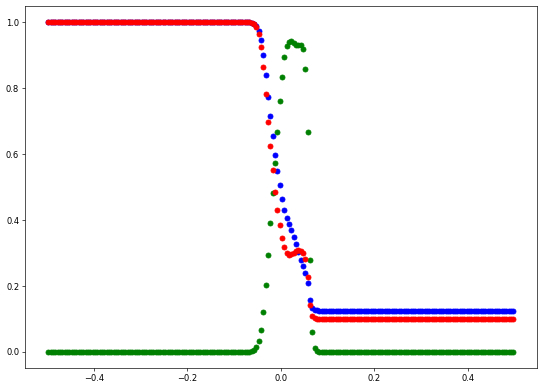

0.033212121212121214


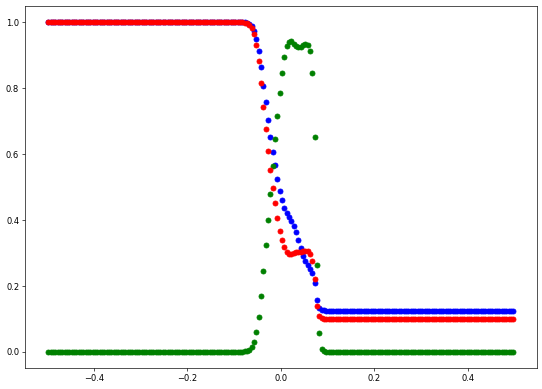

0.04151515151515151


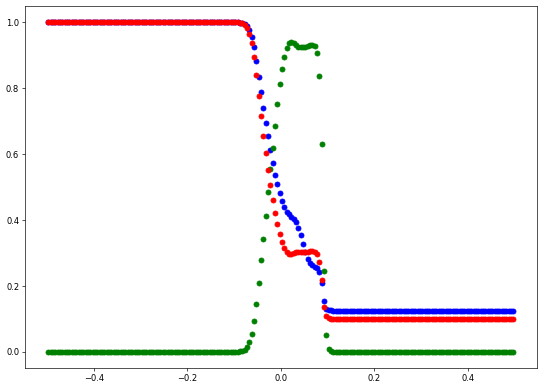

0.04981818181818182


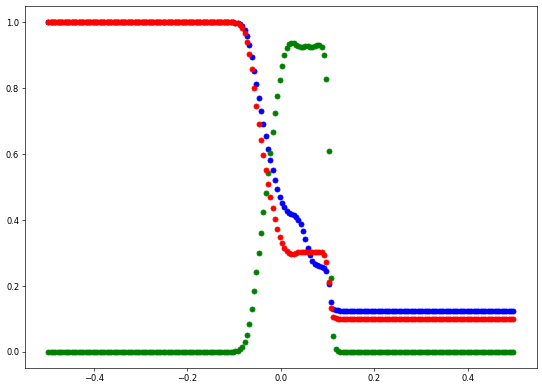

0.05812121212121212


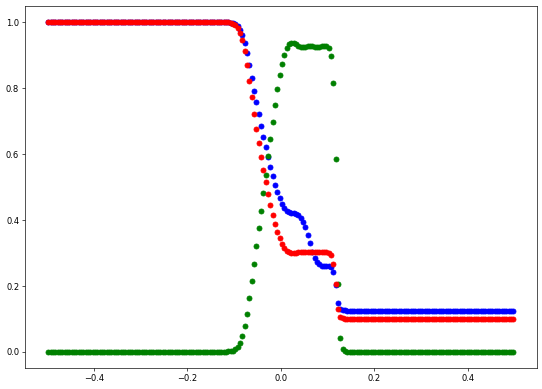

0.06642424242424243


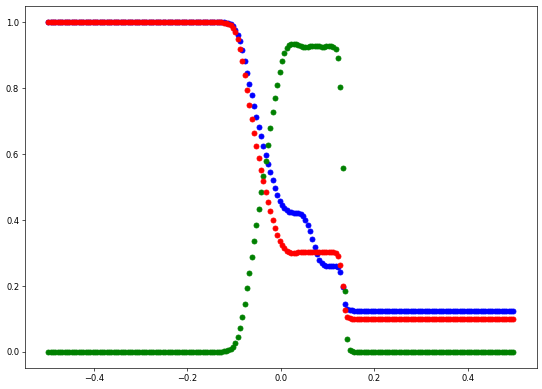

0.07472727272727273


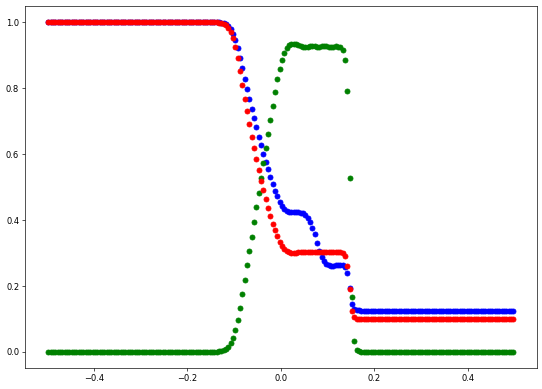

0.08303030303030302


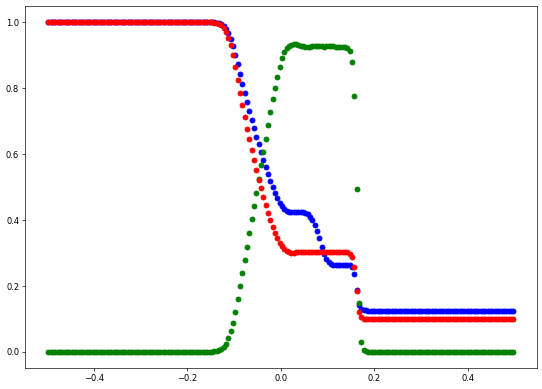

0.09133333333333334


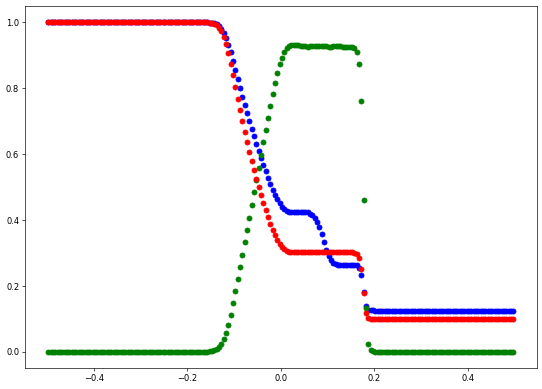

0.09963636363636363


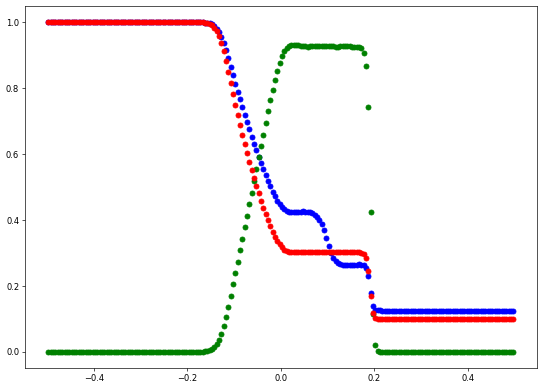

0.10793939393939393


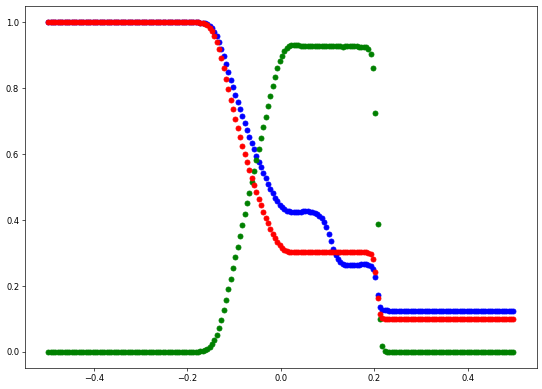

0.11624242424242424


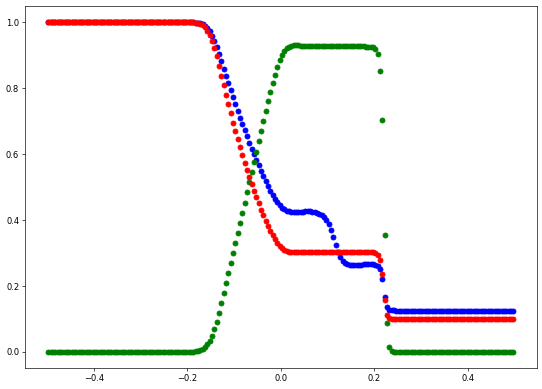

0.12454545454545454


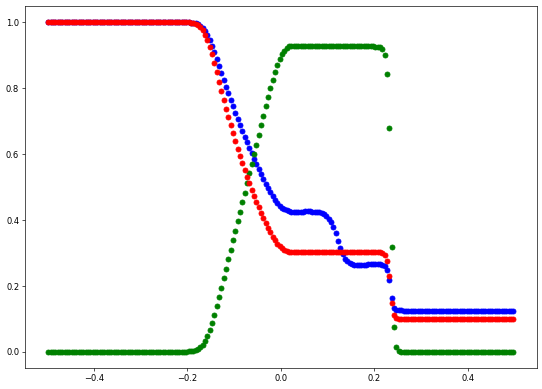

0.13284848484848485


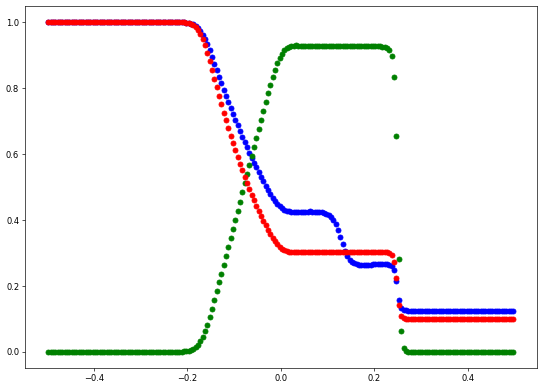

0.14115151515151514


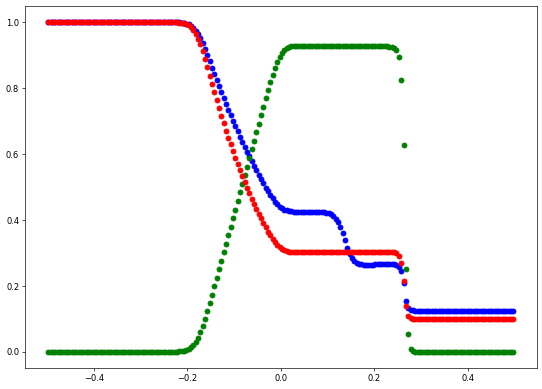

0.14945454545454545


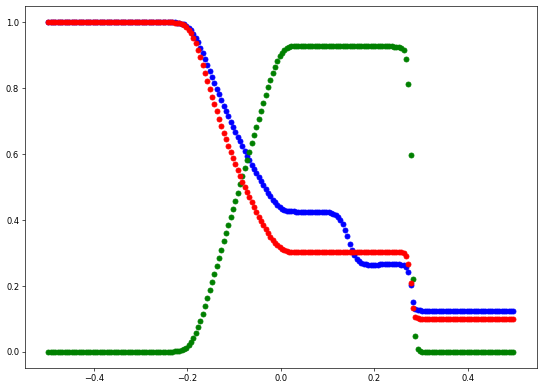

0.15775757575757576
[0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25]


In [28]:
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

%matplotlib inline

N = 200
x = np.linspace(-0.5, 0.5, N+1)
N_t = 100
t = np.linspace(0, 0.1644, N_t)

xc = 0.5*np.array(x[:-1]+x[1:])
xc3 = np.append( xc, np.append(xc, xc) )

dx = x[1] - x[0]

gam = 1.4

u0L = np.append( np.ones(N), np.append(np.zeros(N), 2.5*np.ones(N)) )
u0R = np.append( 0.125*np.ones(N), np.append(np.zeros(N), 0.25*np.ones(N)) )
u0 = np.heaviside(xc3, 0)*u0R + np.heaviside(-xc3, 1)*u0L

plt.plot(xc, u0[:N])
plt.plot(xc, u0[N:2*N])
plt.plot(xc, u0[2*N:])
plt.show()

start = time.time()  

def minmod2(a, b):
  minmod = (np.abs(a) < np.abs(b)).astype(int)
  minmod2 = (np.abs(b) < np.abs(a)).astype(int)
  return 1/2*(np.sign(a) + np.sign(b))*(minmod*np.abs(a) + minmod2*np.abs(b))

def gen_minmod(a, b, c):
  th = 1
  maximum = np.maximum(th*a, np.maximum(b, th*c))
  minimum = np.minimum(th*a, np.minimum(b, th*c))
  hs_pos = np.heaviside(a, 1)*np.heaviside(b, 1)*np.heaviside(c, 1)
  hs_neg = np.heaviside(-a, 1)*np.heaviside(-b, 1)*np.heaviside(-c, 1)
  return minimum*hs_pos + maximum*hs_neg

def flux(rho, m, e):
  return np.append(m, np.append((-1 + gam)*(e - m**2/(2.*rho)) + m**2/rho, (m*(e + (-1 + gam)*(e - m**2/(2.*rho))))/rho ) )

def char2(f, u):
  f = np.append(f[0] - (f[1] - f[0]), np.append(f, f[-1] + (f[-1] - f[-2])))
  u = np.append(u[0] - (u[1] - u[0]), np.append(u, u[-1] + (u[-1] - u[-2])))
  du1, du2 = u[1:-1] - u[:-2], u[2:] - u[1:-1]
  jac = gen_minmod(np.nan_to_num( (f[1:-1] - f[:-2])/du1 ), np.nan_to_num( (f[2:] - f[:-2])/(du1 + du2) ), np.nan_to_num( (f[2:] - f[1:-1])/du2) )
  #print(jac)
  return np.ones(len(jac))

def construct_u(u):
  u = np.append(u[0], np.append(u, u[-1]))
  limiter = gen_minmod((u[1:-1] - u[:-2])/dx, (u[2:] - u[:-2])/dx, (u[2:] - u[1:-1])/dx)
  uLForw = u[0]
  uLCent = u[1:-1] + dx/2*limiter
  uL = np.append(uLForw, uLCent)
  
  uRBack = u[-1]
  uRCent = u[1:-1] - dx/2*limiter
  uR = np.append(uRCent, uRBack)
  return (uL, uR)

def dudt(t, u):
  rho, m, e = u[:int(len(u)/3)], u[int(len(u)/3):int(len(u)*2/3)], u[int(2/3*len(u)):] 

  rhoL, rhoR = construct_u(rho)
  mL, mR = construct_u(m)
  eL, eR = construct_u(e)
  uL, uR = np.append(rhoL, np.append(mL, eL)), np.append(rhoR, np.append(mR, eR))

  FL = flux(rhoL, mL, eL)
  FR = flux(rhoR, mR, eR)
 
  FL_d = spectral_radius(rhoL, mL, eL)
  FR_d = spectral_radius(rhoR, mR, eR)
  FL_d = np.append(FL_d, np.append(FL_d, FL_d))
  FR_d = np.append(FR_d, np.append(FR_d, FR_d))

  prop = (FL_d >= FR_d).astype(int)*FL_d + (FL_d < FR_d).astype(int)*FR_d

  fu_interface = (FL + FR)/2 - prop/2*(uR - uL)

  rhs1 = (fu_interface[:N] - fu_interface[1:N+1])/dx
  rhs2 = (fu_interface[N+1:2*N+1] - fu_interface[N+2:2*N+2])/dx
  rhs3 = (fu_interface[2*N+2:3*N+2] - fu_interface[2*N+3:])/dx
  dudt = np.append(rhs1, np.append(rhs2, rhs3))
  return dudt
  
def solution(u0):
    t_span = [t[0], t[-1]]
    sol = solve_ivp(dudt, t_span, u0, t_eval = t, rtol=1e-13, atol=1e-13)
    return sol.y

sol = solution(u0)

print(time.time()-start)

plt.figure(figsize=(8, 10), dpi= 60, facecolor='w', edgecolor='k')

for i in range(0, N_t, int(N_t/20)):
    plt.figure(figsize=(11, 8), dpi= 60, facecolor='w', edgecolor='k')
    plt.scatter(xc, sol[:N,i], color='blue')
    plt.scatter(xc, sol[N:2*N,i]/sol[:N,i], color='green')
    plt.scatter(xc, (gam - 1)*(sol[2*N:,i] - sol[:N,i]/2*(sol[N:2*N,i]/sol[:N,i])**2), color='red')
    plt.show()
    print(t[i])
    
print(sol[-1])

**Alternative approximation to the flux derivatives**

(Work in progress...)

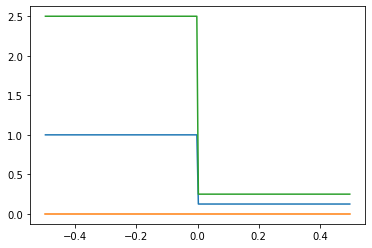

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide


12.55461311340332


<Figure size 480x600 with 0 Axes>

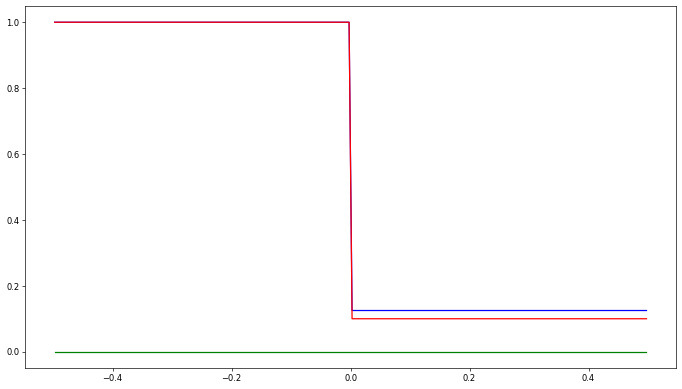

0.0


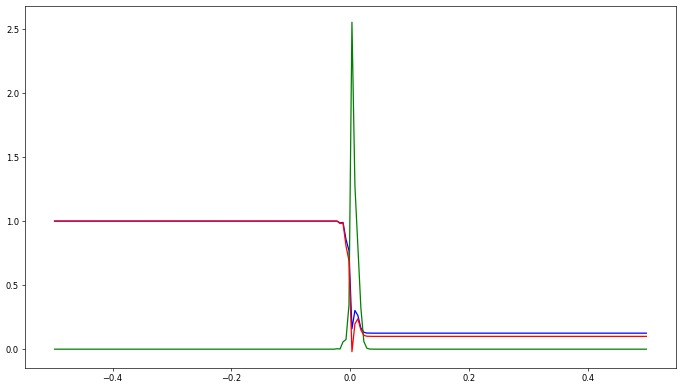

0.00808080808080808


IndexError: ignored

<Figure size 840x480 with 0 Axes>

In [23]:
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

%matplotlib inline

N = 200
x = np.linspace(-0.5, 0.5, N+1)
N_t = 100
t = np.linspace(0, 0.16, N_t)

xc = 0.5*np.array(x[:-1]+x[1:])
xc3 = np.append( xc, np.append(xc, xc) )

dx = x[1] - x[0]

gam = 1.4

u0L = np.append( np.ones(N), np.append(np.zeros(N), 2.5*np.ones(N)) )
u0R = np.append( 0.125*np.ones(N), np.append(np.zeros(N), 0.25*np.ones(N)) )
u0 = np.heaviside(xc3, 0)*u0R + np.heaviside(-xc3, 1)*u0L

plt.plot(xc, u0[:N])
plt.plot(xc, u0[N:2*N])
plt.plot(xc, u0[2*N:])
plt.show()

start = time.time()  

def minmod2(a, b):
  minmod = (np.abs(a) < np.abs(b)).astype(int)
  minmod2 = (np.abs(b) < np.abs(a)).astype(int)
  return 1/2*(np.sign(a) + np.sign(b))*(minmod*np.abs(a) + minmod2*np.abs(b))

def gen_minmod(a, b, c):
  th = 1
  maximum = np.maximum(th*a, np.maximum(b, th*c))
  minimum = np.minimum(th*a, np.minimum(b, th*c))
  hs_pos = np.heaviside(a, 1)*np.heaviside(b, 1)*np.heaviside(c, 1)
  hs_neg = np.heaviside(-a, 1)*np.heaviside(-b, 1)*np.heaviside(-c, 1)
  return minimum*hs_pos + maximum*hs_neg

def flux(rho, m, e):
  return np.append(m, np.append((-1 + gam)*(e - m**2/(2.*rho)) + m**2/rho, (m*(e + (-1 + gam)*(e - m**2/(2.*rho))))/rho ) )

def char2(f, u):
  f = np.append(f[0] - (f[1] - f[0]), np.append(f, f[-1] + (f[-1] - f[-2])))
  u = np.append(u[0] - (u[1] - u[0]), np.append(u, u[-1] + (u[-1] - u[-2])))
  du1, du2 = u[1:-1] - u[:-2], u[2:] - u[1:-1]
  jac = gen_minmod(np.nan_to_num( (f[1:-1] - f[:-2])/du1 ), np.nan_to_num( (f[2:] - f[:-2])/(du1 + du2) ), np.nan_to_num( (f[2:] - f[1:-1])/du2) )
  return jac

def construct_u(u):
  u = np.append(u[0], np.append(u, u[-1]))
  limiter = gen_minmod((u[1:-1] - u[:-2])/dx, (u[2:] - u[:-2])/dx, (u[2:] - u[1:-1])/dx)
  uLForw = u[0]
  uLCent = u[1:-1] + dx/2*limiter
  uL = np.append(uLForw, uLCent)
  
  uRBack = u[-1]
  uRCent = u[1:-1] - dx/2*limiter
  uR = np.append(uRCent, uRBack)
  return (uL, uR)

def dudt(t, u):
  rho, m, e = u[:int(len(u)/3)], u[int(len(u)/3):int(len(u)*2/3)], u[int(2/3*len(u)):] 

  rhoL, rhoR = construct_u(rho)
  mL, mR = construct_u(m)
  eL, eR = construct_u(e)
  uL, uR = np.append(rhoL, np.append(mL, eL)), np.append(rhoR, np.append(mR, eR))

  FL = flux(rhoL, mL, eL)
  FR = flux(rhoR, mR, eR)
  FL_d = char2(FL, uL)
  FR_d = char2(FR, uR)

  prop = (FL_d >= FR_d).astype(int)*FL_d + (FL_d < FR_d).astype(int)*FR_d

  fu_interface = (FL + FR)/2 - prop/2*(uR - uL)

  rhs1 = (fu_interface[:N] - fu_interface[1:N+1])/dx
  rhs2 = (fu_interface[N+1:2*N+1] - fu_interface[N+2:2*N+2])/dx
  rhs3 = (fu_interface[2*N+2:3*N+2] - fu_interface[2*N+3:])/dx
  dudt = np.append(rhs1, np.append(rhs2, rhs3))
  return dudt
  
def solution(u0):
    t_span = [t[0], t[-1]]
    sol = solve_ivp(dudt, t_span, u0, t_eval = t, rtol=1e-13, atol=1e-13)
    return sol.y

sol = solution(u0)

print(time.time()-start)

plt.figure(figsize=(8, 10), dpi= 60, facecolor='w', edgecolor='k')

for i in range(0, N_t, int(N_t/20)):
    plt.figure(figsize=(14, 8), dpi= 60, facecolor='w', edgecolor='k')
    plt.plot(xc, sol[:N,i], color='blue')
    plt.plot(xc, sol[N:2*N,i]/sol[:N,i], color='green')
    plt.plot(xc, (gam - 1)*(sol[2*N:,i] - sol[:N,i]/2*(sol[N:2*N,i]/sol[:N,i])**2), color='red')
    plt.show()
    print(t[i])
    
print(sol[-1])